# Analytic valuation of the callable convertible discount bonds:Equivalent decomposition method

## Data preparation

In [2]:
import pandas_market_calendars as mcal
import pandas as pd
from ic_group import *
from visualize import *
import numpy as np
from datetime import datetime
from scipy.stats import norm

In [3]:
data= pd.read_csv('df_call_historic_vol_y.csv')
data= data.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])
data

,date,order_book_id,open,high,low,close,volume,money,num_trades,value_date,...,historic_vol_20,call_historic_vol_20,historic_vol_60,call_historic_vol_60,historic_vol_250,call_historic_vol_250,time_to_maturity,time_to_protection,non_zero_vol,ccb_option
0,2019-01-02,113011.XSHG,105.000,105.470,103.400,103.780,823250.0,8.566986e+07,0.0,2017-03-17,...,NaN,NaN,NaN,NaN,NaN,NaN,4.205479,0.000100,NaN,NaN
1,2019-01-02,110030.XSHG,102.260,102.350,102.250,102.320,18810.0,1.924131e+06,0.0,2014-12-25,...,NaN,NaN,NaN,NaN,NaN,NaN,0.978082,0.000100,NaN,NaN
2,2019-01-02,113510.XSHG,93.100,93.400,93.010,93.030,1920.0,1.791770e+05,0.0,2018-06-19,...,NaN,NaN,NaN,NaN,NaN,NaN,5.465753,0.000100,NaN,NaN
3,2019-01-02,128042.XSHE,94.600,94.986,94.380,94.748,12151.0,1.149000e+06,97.0,2018-07-30,...,NaN,NaN,NaN,NaN,NaN,NaN,5.578082,0.076712,NaN,NaN
4,2019-01-02,113017.XSHG,92.000,92.150,91.470,92.060,38480.0,3.539767e+06,0.0,2017-12-27,...,NaN,NaN,NaN,NaN,NaN,NaN,4.986301,0.000100,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350358,2023-07-04,123046.XSHE,411.738,416.715,406.919,412.990,575280.0,2.370410e+08,17278.0,2020-03-19,...,150.163784,193.861893,121.845521,193.861893,74.424644,193.861893,2.709589,0.000100,150.163784,193.861893
350359,2023-07-04,128030.XSHE,235.477,238.500,224.737,228.977,191480.0,4.373473e+07,3464.0,2017-12-22,...,33.576373,109.107625,31.021104,108.081857,25.166239,104.833510,0.468493,0.000100,33.576373,114.345404
350360,2023-07-04,127014.XSHE,228.777,232.311,227.350,228.698,1595470.0,3.666792e+08,31076.0,2019-10-24,...,60.277292,204.743589,67.333294,204.743590,71.714223,204.743590,2.309589,0.000100,60.277292,204.743590
350361,2023-07-04,123104.XSHE,112.300,114.550,111.202,112.900,1148312.0,1.292685e+08,19396.0,2021-03-16,...,14.697374,43.631996,8.200944,43.242911,3.943933,39.821342,3.701370,0.000100,14.697374,43.647657


## CCDB model

In [4]:
def ccdb(S0,BF,P1,P2,T,r,vol):
    """
    reference:Analytic valuation of the callable convertible discount bonds:Equivalent decomposition method 
    input:
    BF  面值(par_value)
    S0  在当前时刻标的股价(stock_close)
    P1  转股价(coversion_price)
    P2  赎回(default 130)
    T   剩余期限(time_to_maturity)
    r   无风险log return(default np.log(1.02))
    vol 波动率
    """
    return (BF/P1)*ABC_i1(S0,T,P1,P2,r,vol)+(BF/P1)*UOC(S0,T,P1,P2,r,vol)+ABC_i2(S0,T,BF,P2,r,vol)-ABC_d(BF,S0,T,P2,r,vol)+DB(BF,T,r)

# 由于计算过程冗杂，出现复杂表达式，以下表达式主要用于简化
# u=(r-vol**2/2)/vol
# u_hat=(r+vol**2/2)/(vol**2)
# x=(np.log(S0/P2))/(vol*np.sqrt(T))+u_hat*vol*np.sqrt(T)
# d1=(np.log(S0/P1)+(r+vol**2/2)*T)/(vol*np.sqrt(T))
# z=(np.log(P2/S0))/(vol*np.sqrt(T))+u_hat*vol*np.sqrt(T)
# z1=(np.log(P2**2/(P1*S0)))/(vol*np.sqrt(T))+u_hat*vol*np.sqrt(T)
# u_tu=np.sqrt(u**2+2*r)
# y=np.log(P2/S0)/vol
# a1=(y+u_tu*T)/np.sqrt(T)
# a2=(y-u_tu*T)/np.sqrt(T)
# a3=(y+u*T)/np.sqrt(T)
# a4=(y-u*T)/np.sqrt(T)

def ABC_i1(S0,T,P1,P2,r,vol): # 投资者拥有的障碍水平为P2，固定支付额为(P2-P1)的立即支付型规则美式二期买权
    u=(r-vol**2/2)/vol
    u_tu=np.sqrt(u**2+2*r)
    y=np.log(P2/S0)/vol
    a1=(y+u_tu*T)/np.sqrt(T)
    a2=(y-u_tu*T)/np.sqrt(T)
    return (P2-P1)*np.exp(y*(u-u_tu))*(norm.cdf(-a2)+np.exp(2*y*u_tu)*norm.cdf(-a1))

def UOC(S0,T,P1,P2,r,vol): # 投资者拥有的执行价格为P1，障碍水平为P2的规则向上敲出买权
    u_hat=(r+vol**2/2)/(vol**2)
    d1=(np.log(S0/P1)+(r+vol**2/2)*T)/(vol*np.sqrt(T))
    x=(np.log(S0/P2))/(vol*np.sqrt(T))+u_hat*vol*np.sqrt(T)
    z=(np.log(P2/S0))/(vol*np.sqrt(T))+u_hat*vol*np.sqrt(T)
    z1=(np.log(P2**2/(P1*S0)))/(vol*np.sqrt(T))+u_hat*vol*np.sqrt(T)
    return S0*(norm.cdf(d1)-norm.cdf(x))+P1*np.exp(-r*T)*(norm.cdf(x-vol*np.sqrt(T))-norm.cdf(d1-vol*np.sqrt(T)))\
        +S0*((P2/S0)**(2*u_hat))*(norm.cdf(-z)-norm.cdf(-z1))\
        +P1*np.exp(-r*T)*((P2/S0)**(2*u_hat-2))*(norm.cdf(-z1+vol*np.sqrt(T))-norm.cdf(-z+vol*np.sqrt(T)))

def ABC_i2(S0,T,BF,P2,r,vol): # 投资者拥有的障碍水平为P2，固定支付额为BF的立即支付型规则美式二期买权
    u=(r-vol**2/2)/vol
    u_tu=np.sqrt(u**2+2*r)
    y=np.log(P2/S0)/vol
    a1=(y+u_tu*T)/np.sqrt(T)
    a2=(y-u_tu*T)/np.sqrt(T)
    return BF*np.exp(y*(u-u_tu))*(norm.cdf(-a2)+np.exp(2*y*u_tu)*norm.cdf(-a1))

def ABC_d(BF,S0,T,P2,r,vol): #发行者拥有的障碍水平为P2，固定支付额为BF的延迟支付型规则美式二期买权
    u=(r-vol**2/2)/vol
    y=np.log(P2/S0)/vol
    a3=(y+u*T)/np.sqrt(T)
    a4=(y-u*T)/np.sqrt(T)
    return BF*np.exp(-r*T)*(norm.cdf(-a4)+(P2/S0)**((2*r-vol**2)/(vol**2))*norm.cdf(-a3))

def DB(BF,T,r): #贴现债券
    return BF*np.exp(-r*T)

In [26]:
data['ccdb'] = data.apply(lambda row: ccdb(row['stock_close'],row['par_value'],row['conversion_price'],130,row['time_to_maturity'],np.log(1.02),row['non_zero_vol']), axis=1)

In [27]:
data['conversion_value']

0          88.377724
1          58.501441
2          63.427562
3          77.509434
4          69.594595
             ...    
350358    193.861893
350359    114.345404
350360    204.743590
350361     43.647657
350362     81.006393
Name: conversion_value, Length: 350363, dtype: float64

In [28]:
data[['close','ccdb']]

,close,ccdb
0,103.780,NaN
1,102.320,NaN
2,93.030,NaN
3,94.748,NaN
4,92.060,NaN
...,...,...
350358,412.990,283.111427
350359,228.977,207.164282
350360,228.698,288.537319
350361,112.900,131.051380


In [21]:
def plot_comparison(df_i,order_book_id,mode):
    """
    Show the plot of close price and theoretically predicted price.
    The volitility is also shown in the plot.
    ------
    Parameter:
    df_i(dataframe): the dataframe with the price of one mode.
    order_book_id(str)
    mode(str): chosen from 'BSM_rq_iv', 'BSM_nt_iv', 'BSM_his_vol'
    ------
    Output:
    Line plot
    """
    if mode == 'BSM_rq_iv':
        call_name='call_rq_iv'
        vol_name='IMPLIEDVOL'
    elif mode == 'BSM_nt_iv':
        call_name='call_nt_iv'
        vol_name='IV_ConvBond'
    elif mode == 'ccdb':
        call_name='ccdb'
        vol_name='non_zero_vol'
    else: # BSM_his_vol
        winlen = mode.split("_")[-1]
        call_name=f'call_historic_vol_{winlen}'
        vol_name=f'historic_vol_{winlen}'

    x = df_i['date']
    y1 = (df_i[call_name]).shift(-1)
    y2 = df_i[vol_name]
    y3 = df_i['close']
    fig, ax1 = plt.subplots()

    # Plot the first dataset
    ax1.plot(x, y1, 'b-', label='ccdb')
    ax1.plot(x, y3, 'r', label='close')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price', color='b')
    ax1.tick_params('y', colors='b')

    # Create the second subplot
    ax2 = ax1.twinx()

    # Plot the second dataset
    ax2.plot(x, y2, 'g', label='vol')
    ax2.set_ylabel('VOL', color='r')
    ax2.tick_params('y', colors='r')

    # Add a legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')
    plt.title(order_book_id)
    # Display the plot
    plt.show()

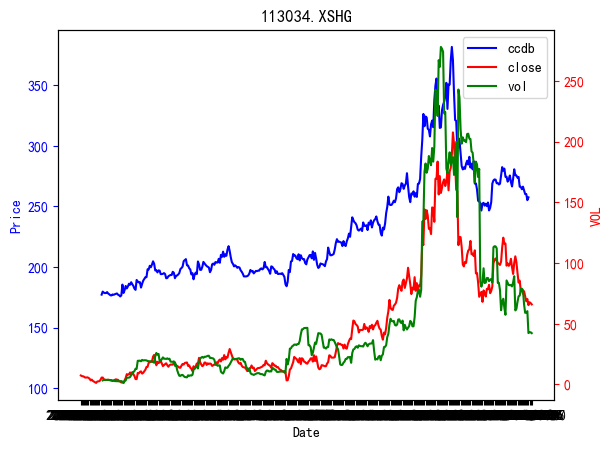

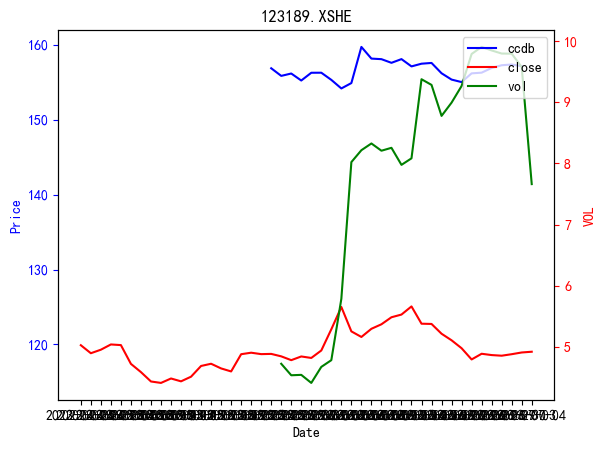

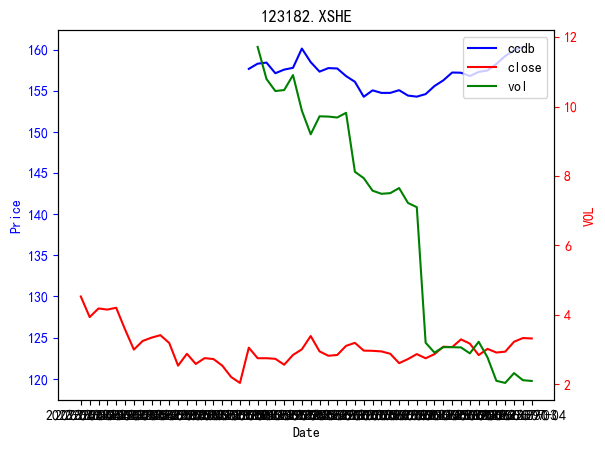

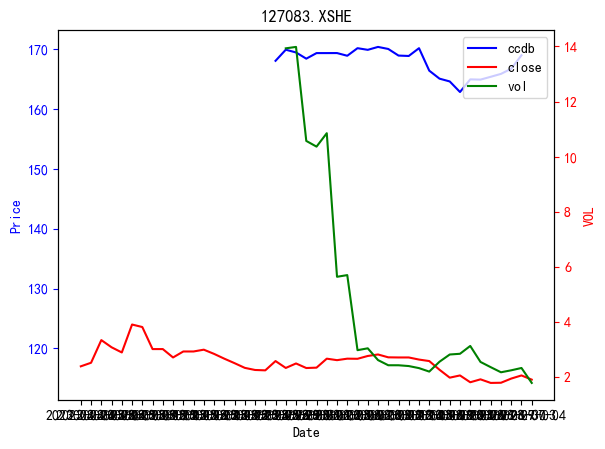

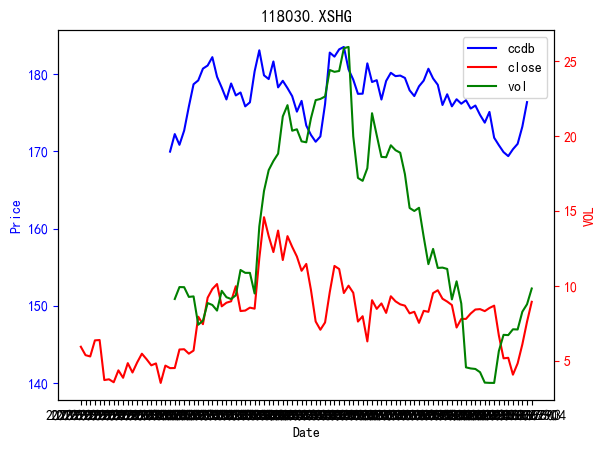

In [29]:
order_book_id_lis = list(set(data['order_book_id']))
# plot of some examples
for i in range(0,5):
    order_book_id = order_book_id_lis[i]
    df_i = data[data['order_book_id']==order_book_id]
    #mpl.rcParams['font.family'] = 'Times New Roman'
    plot_comparison(df_i,order_book_id,'ccdb')

In [56]:
from visualize import *
from ic_group import *
#mpl.rcParams['font.family'] = 'Times New Roman'
df = data
df = df.sort_values(['order_book_id','date'])
# 构建因子 
# df['factor1'] = np.where(df.order_book_id == df.order_book_id.shift(20),df.close/df.close.shift(20)-1,np.nan)
df['price_diff'] = df['close'] - df['ccdb']
df['factor1']=df['ccdb']/df['close']-1
df['new_price']=df['ccdb']*(df['close'].shift(1)/df['ccdb'].shift(2)\
                            +df['close'].shift(3)/df['ccdb'].shift(4)\
                            +df['close'].shift(5)/df['ccdb'].shift(6)\
                            +df['close'].shift(6)/df['ccdb'].shift(8)\
                            +df['close'].shift(8)/df['ccdb'].shift(10))/5
df['factor2']=np.where(df.order_book_id==df.order_book_id.shift(10),df['new_price']/df['close']-1,0)
factor ='price_diff'
factor1='factor1'
factor2='factor2'
# 预测收益
df['r'] = np.where(df.order_book_id == df.order_book_id.shift(-2),df.open.shift(-2)/df.open.shift(-1)-1,0)
r= 'r'
#data0 = df
data0 = df[['date','order_book_id','r','factor1','factor2',factor]].dropna()
data0 = data0[~np.isinf(data0['r'])]
data0 = data0[data0['date']>'2021-05-01']
data0['date'] = data0['date'].apply(lambda x:str(x)[:10])

In [46]:
data0['factor2']

130992   -0.000182
131352    0.000153
131712   -0.001309
132072   -0.002208
132431    0.000072
            ...   
305417    0.035824
305569    0.000827
306166    0.019174
306644   -0.003480
306987    0.029205
Name: factor2, Length: 210896, dtype: float64

<Figure size 1500x1200 with 0 Axes>

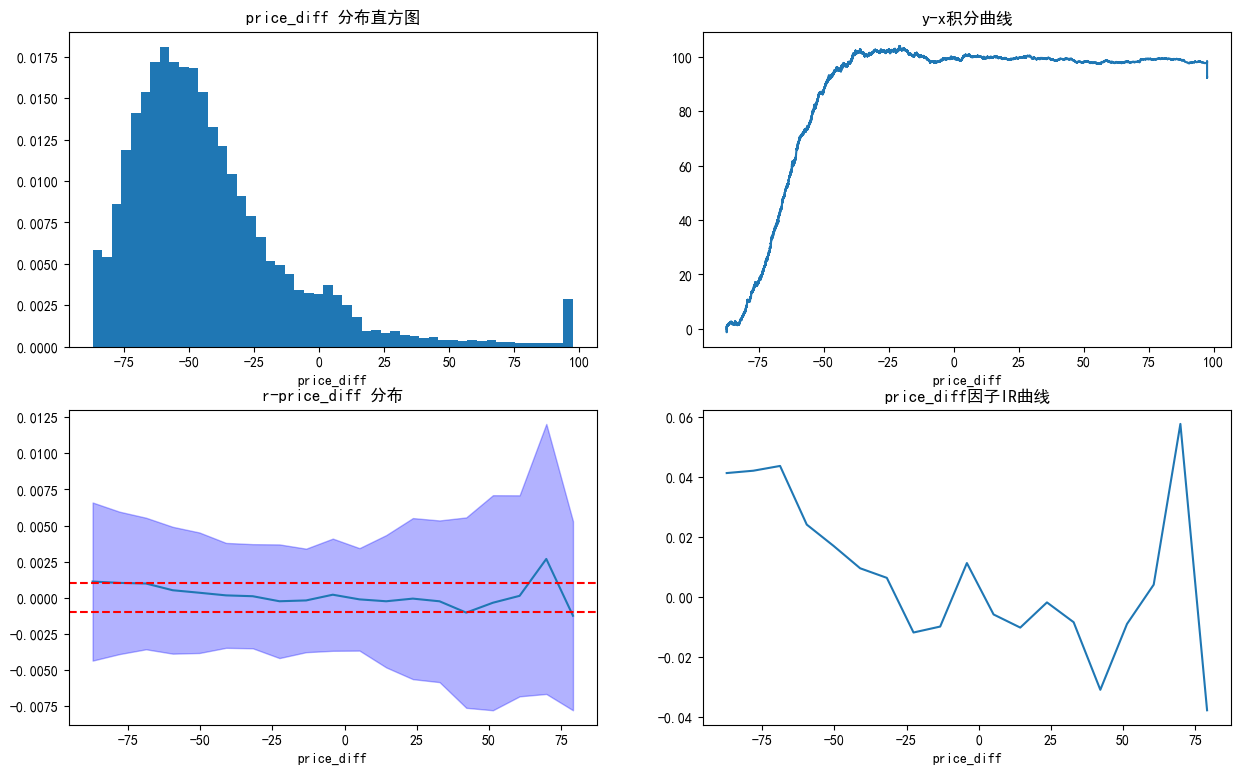

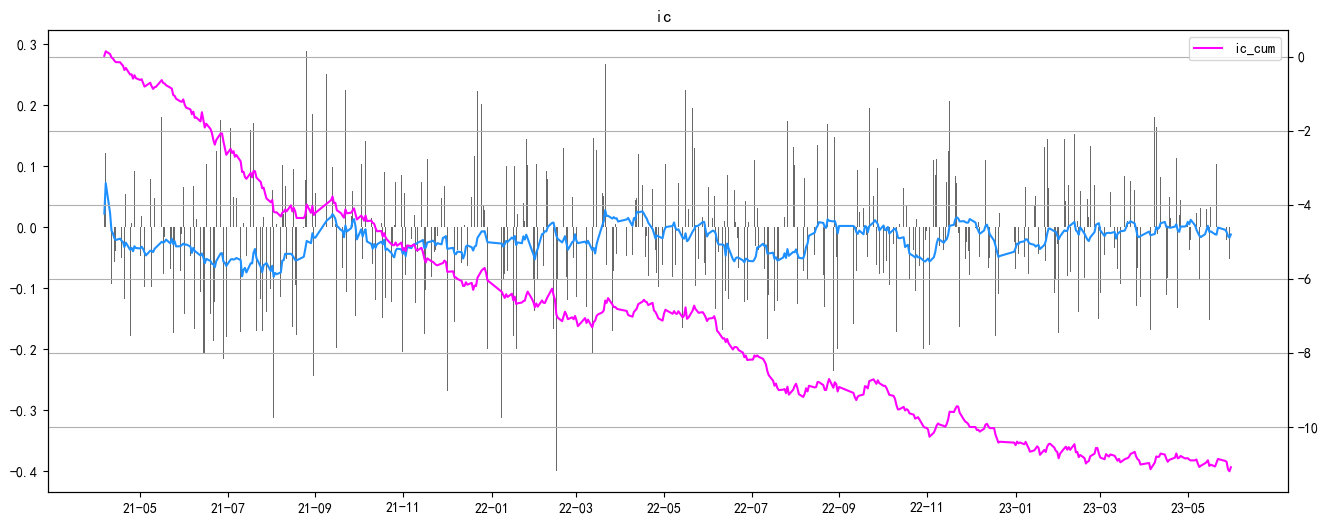

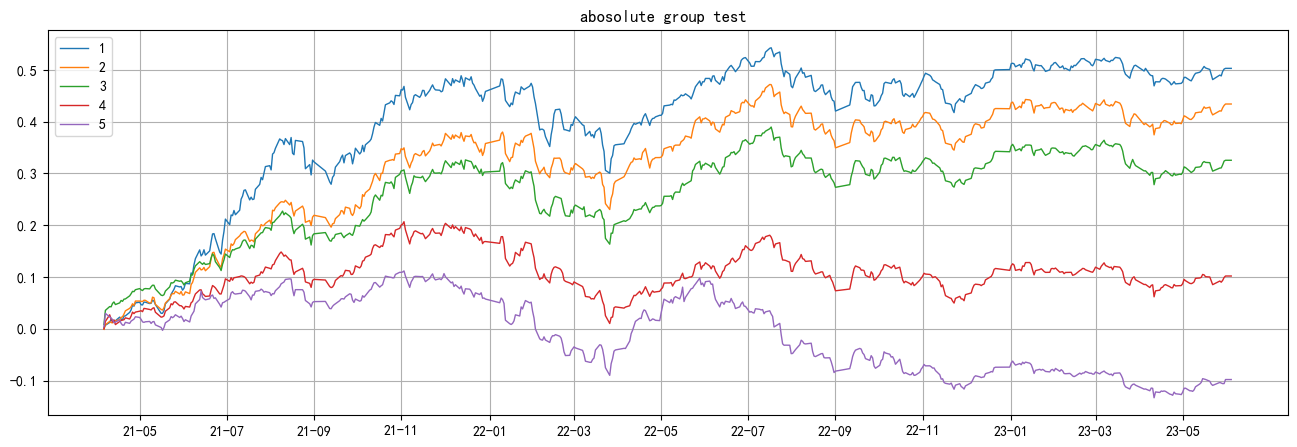

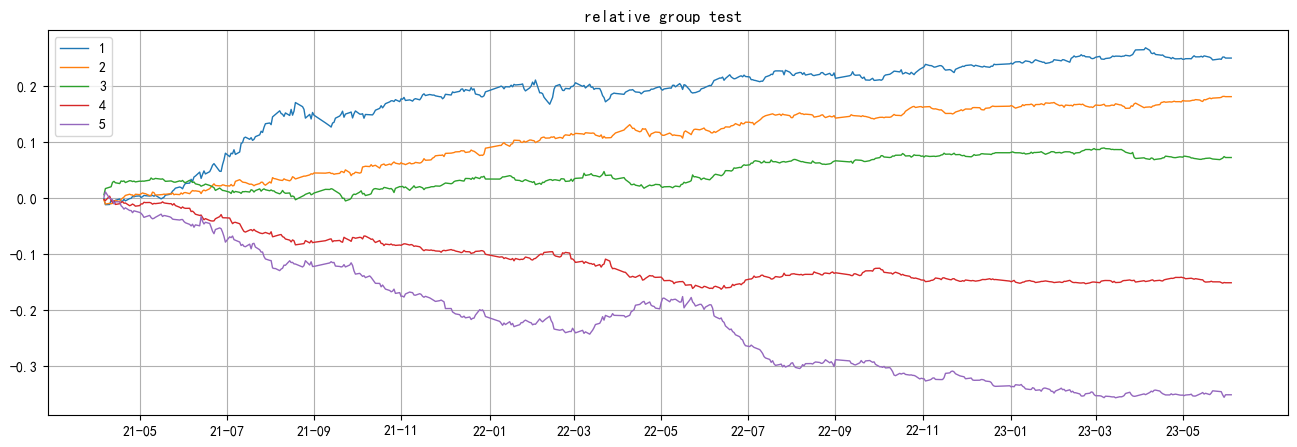

In [53]:
look(data0,factor,r,thresh=0.01, div_num=20)
analyse_ic(data0,factor,r)    
analyse_group_new(data0,factor,r,is_alpha=False,num_group=5)
analyse_group_new(data0,factor,r,is_alpha=True,num_group=5)

<Figure size 1500x1200 with 0 Axes>

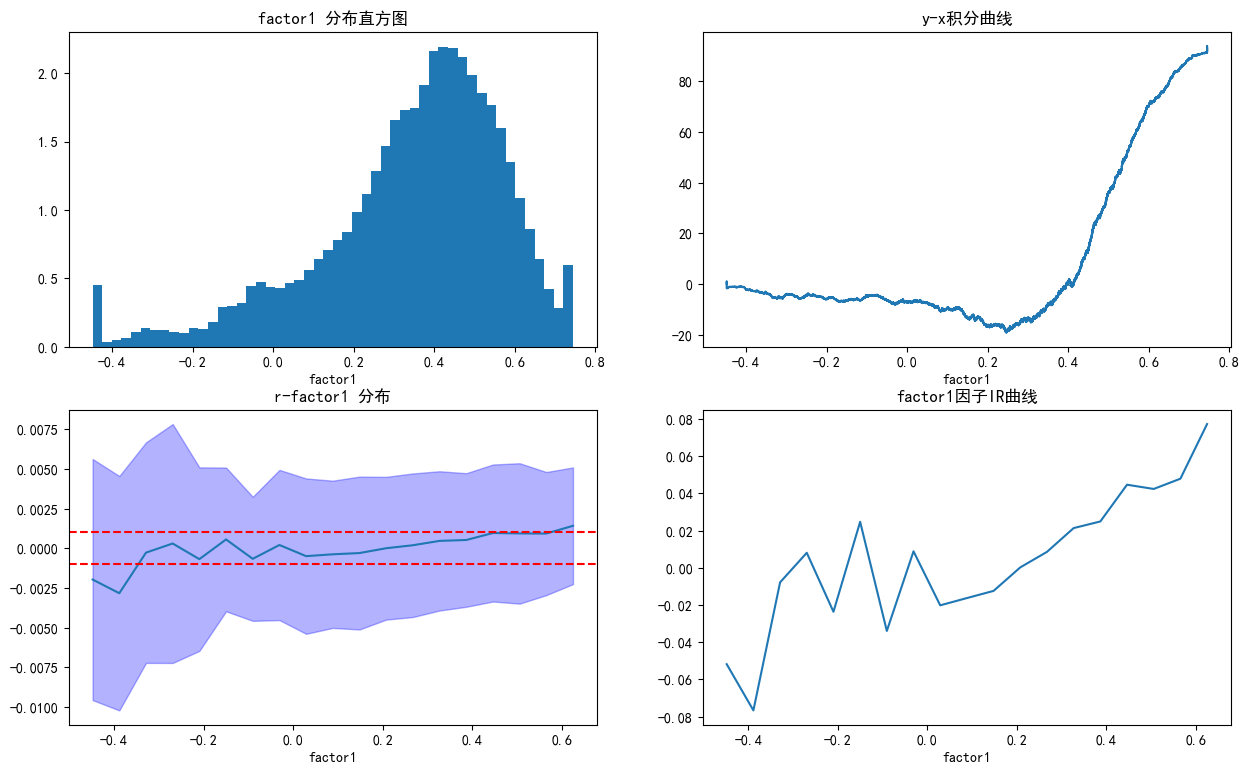

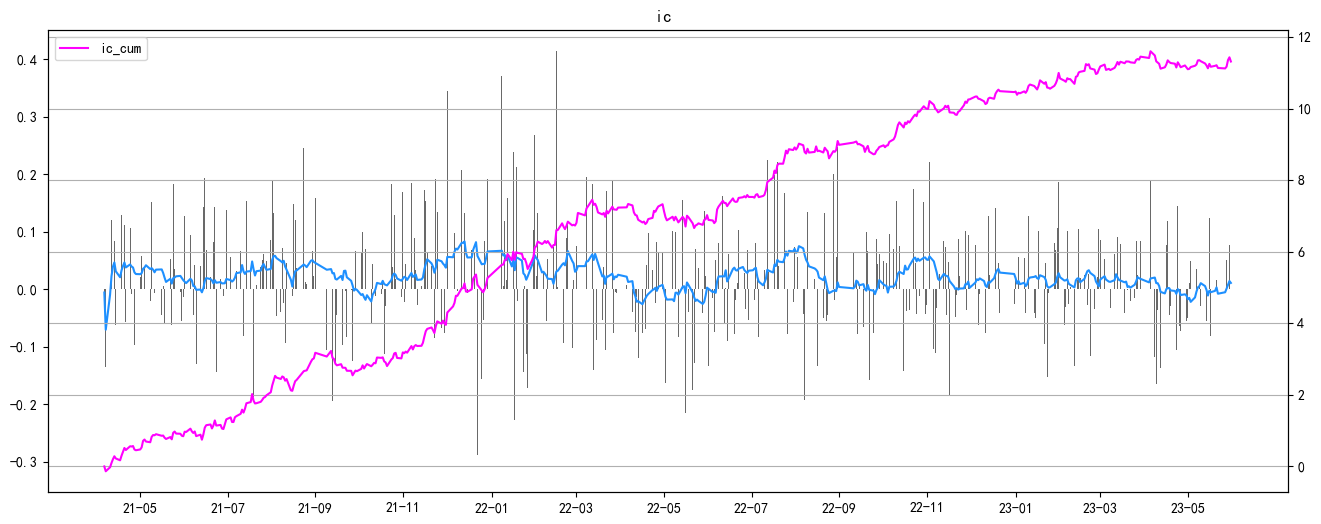

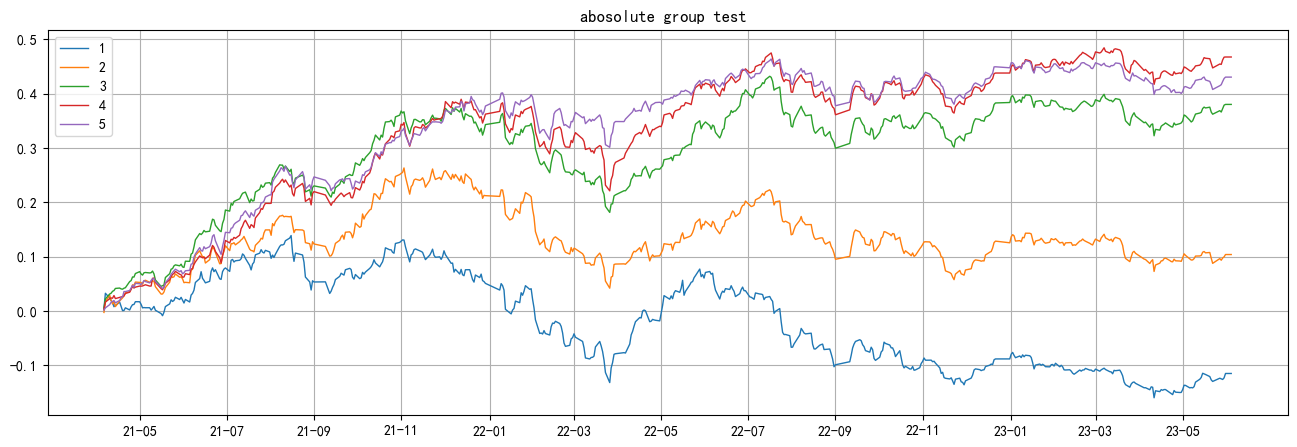

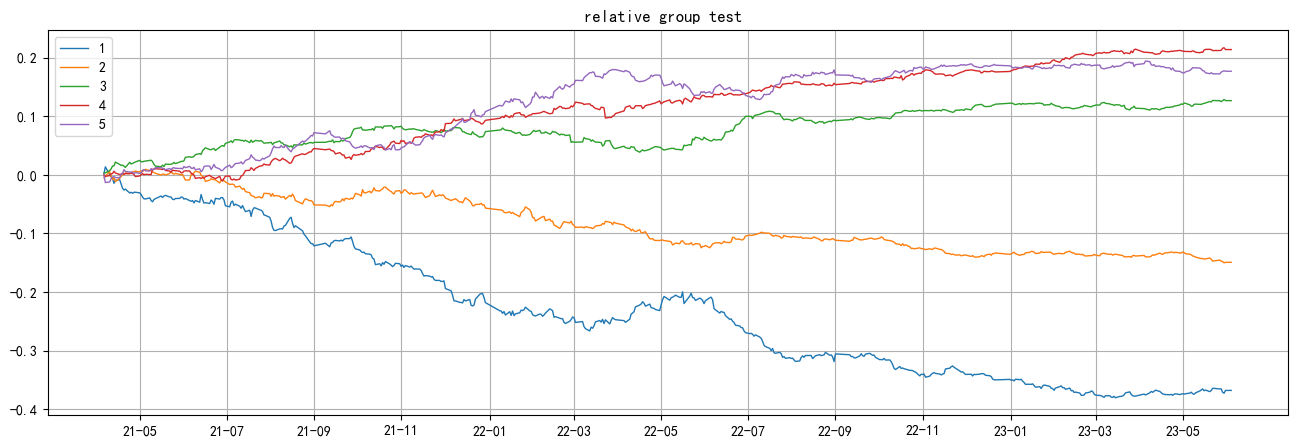

In [51]:
look(data0,factor1,r,thresh=0.01, div_num=20)
analyse_ic(data0,factor1,r)    
analyse_group_new(data0,factor1,r,is_alpha=False,num_group=5)
analyse_group_new(data0,factor1,r,is_alpha=True,num_group=5)

<Figure size 1500x1200 with 0 Axes>

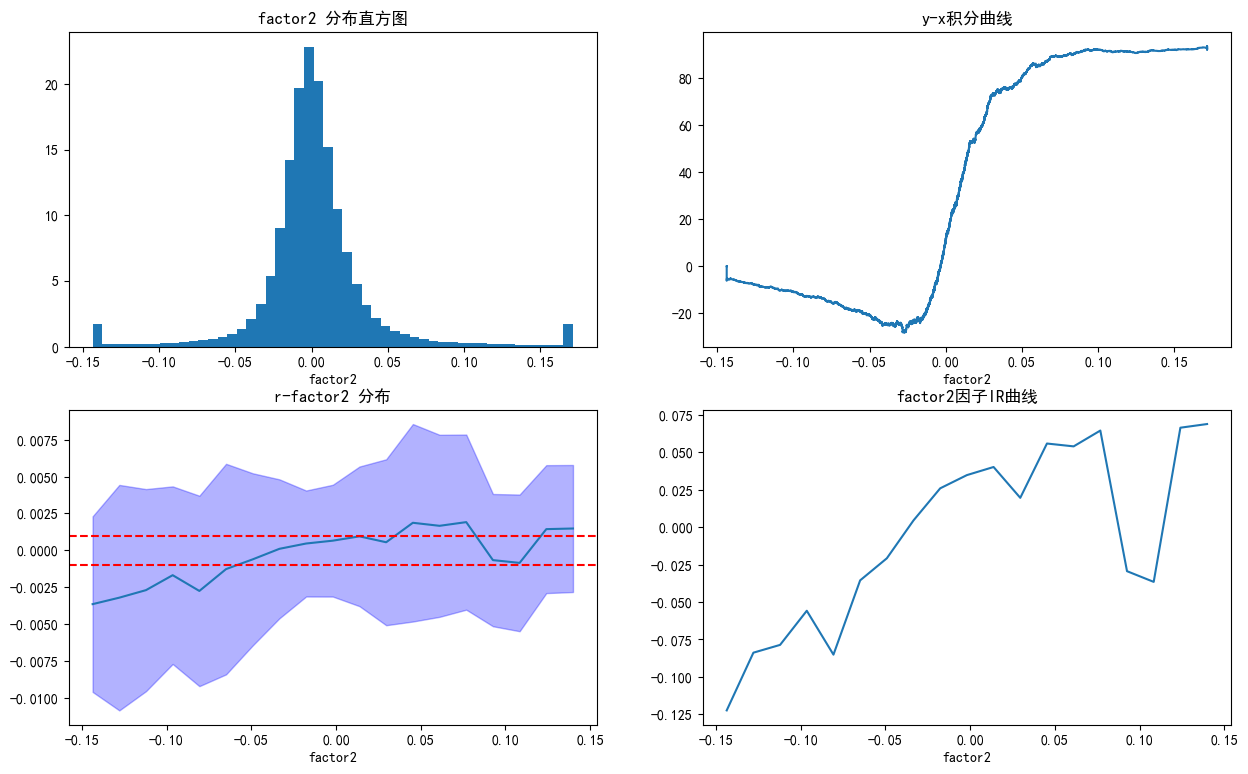

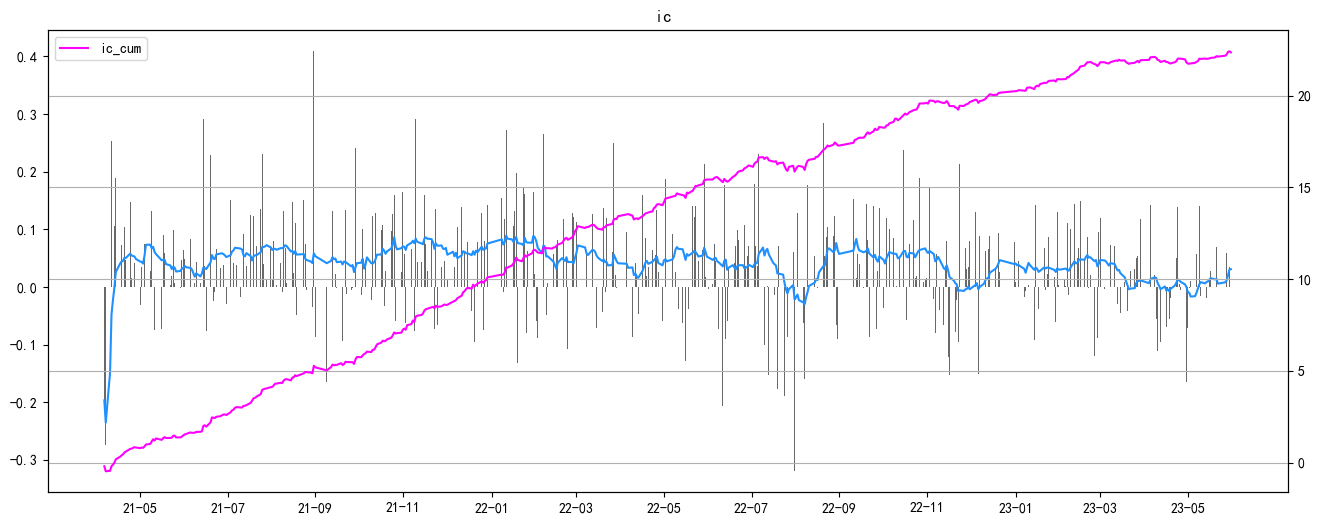

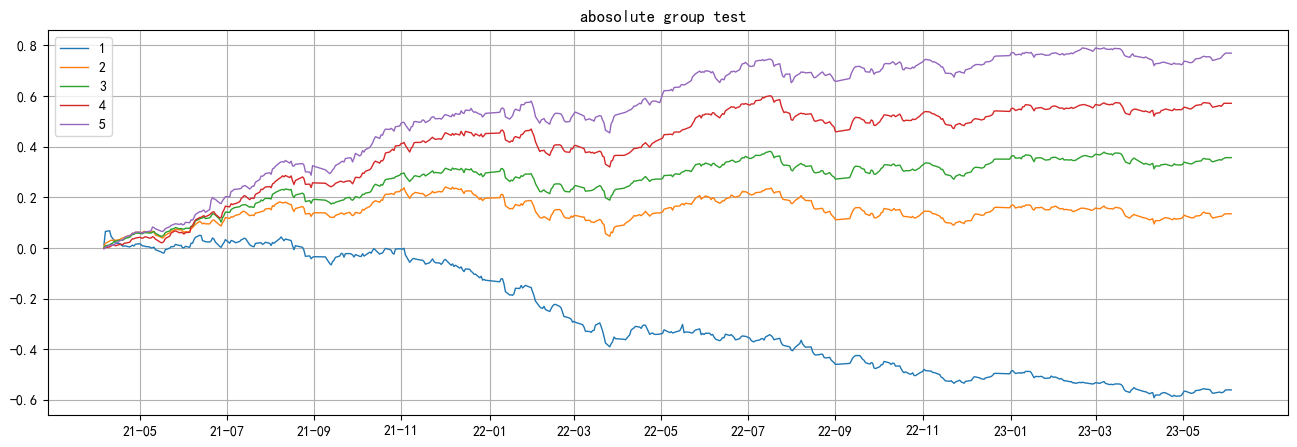

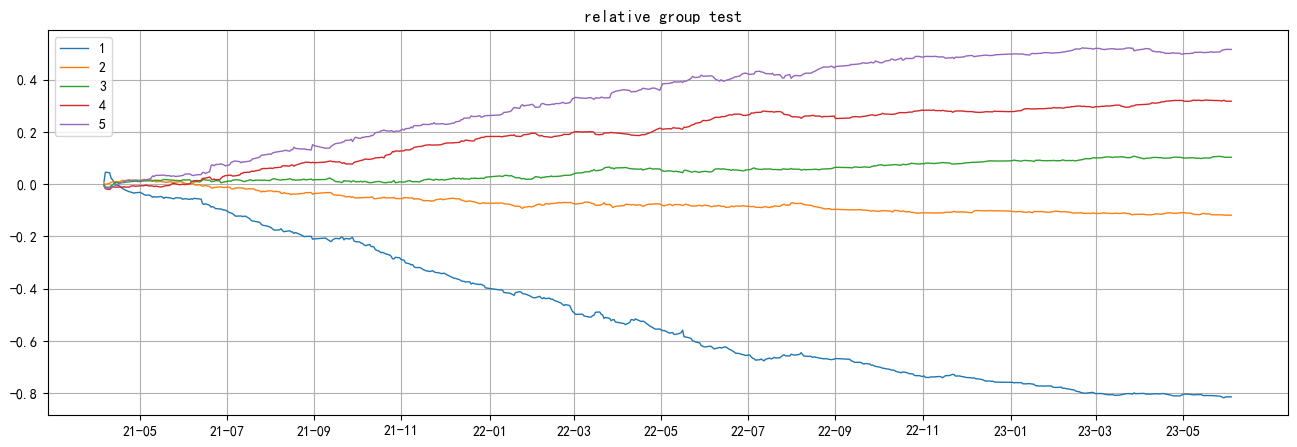

In [57]:
look(data0,factor2,r,thresh=0.01, div_num=20)
analyse_ic(data0,factor2,r)    
analyse_group_new(data0,factor2,r,is_alpha=False,num_group=5)
analyse_group_new(data0,factor2,r,is_alpha=True,num_group=5)